In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Define the file path
file_path = r"C:\Users\skosloff\Documents\Mean-Variance Analysis\BR MV Data 2.xlsx"

# Load the Excel file
# If the file has multiple sheets, specify the sheet name or index
retvol = pd.read_excel(file_path, sheet_name='RetVol')  
corr = pd.read_excel(file_path, sheet_name='Corr')  


# Drop columns
retvol.drop(retvol.columns[[0, 1, 3]], axis=1, inplace=True)

# Set the second row as the column headers
retvol.columns = retvol.iloc[1]
retvol = retvol[2:]  

# Drop columns
corr.drop(corr.columns[[0,1]], axis=1, inplace=True)

# Set the second row as the column headers
corr.columns = corr.iloc[1]
corr = corr[2:]  

# Set index of corr
corr.set_index('Asset', inplace=True)

# Reorder correlation matrix to match retvol
new_order = [
    'U.S. cash', 
    'U.S. government bonds (all maturities)', 
    'U.S. large cap equities', 
    'Hedge funds (global)', 
    'U.S. credit (all maturities)', 
    'U.S. private equity (buyout)', 
    'U.S. small cap equities', 
    'Global infrastructure equity', 
    'Real estate mezzanine debt', 
    'U.S. core real estate'
]

# Reindex the correlation matrix
corr = corr.reindex(index=new_order, columns=new_order)

C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [3]:
# Define expected returns, correlation matrix, and variances for 10 assets
expected_returns = retvol['Expected Return (10yr)'].values
correlations = corr.values
variances = retvol['Volatility'].values


# Convert to float
expected_returns = np.array(expected_returns, dtype=float)
variances = np.array(variances, dtype=float)
correlations = np.array(correlations, dtype=float)

# Convert variances to standard deviations
std_devs = np.sqrt(variances)

# Calculate covariance matrix from correlation matrix and variances
cov_matrix = np.diag(std_devs) @ corr @ np.diag(std_devs)

# Define the number of assets
n_assets = len(expected_returns)

In [49]:
from pypfopt import EfficientFrontier, objective_functions

# Initialize the optimizer
ef = EfficientFrontier(expected_returns, cov_matrix.values.astype(np.float64))

# Add constraints
ef.add_constraint(lambda x: x >= 0.05)
ef.add_constraint(lambda x: x <= 0.4)
ef.add_constraint(lambda x: x[2] >= 0.20)  # Large Cap Equities >= 20%
ef.add_constraint(lambda x: x[3] <= 0.10)  # Credit <= 10%

ef.efficient_return(0.0562)

# Optimize and get the weights
optimized_weights = ef.weights
print(optimized_weights)

[0.28070435 0.09783373 0.2        0.1        0.05       0.05
 0.05       0.07146192 0.05       0.05      ]


In [50]:
expected_return = ef.portfolio_performance(verbose=True)

Expected annual return: 5.6%
Annual volatility: 19.8%
Sharpe Ratio: 0.18


In [48]:
print("Current Portfolio Expected Returns:", expected_returns @ current_weights.T * 100)
print("Current Portfolio Volatility:", np.sqrt(current_weights.T @ cov_matrix @ current_weights) * 100)

Current Portfolio Expected Returns: 5.0525216424599995
Current Portfolio Volatility: 14.505948673571234


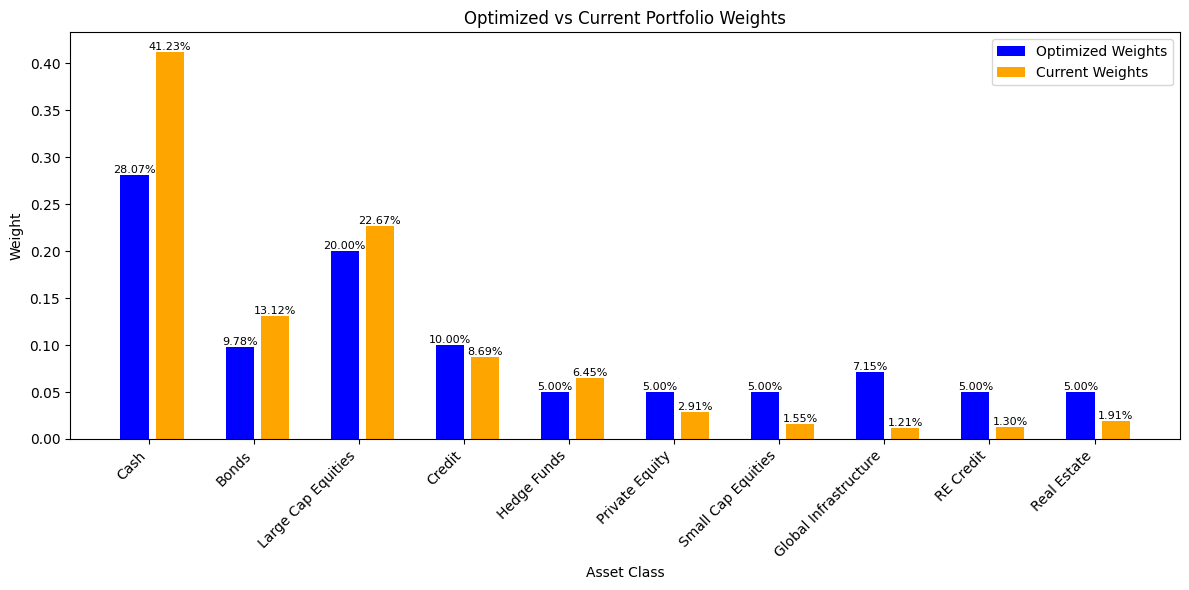

In [51]:
# Plot the optimized weights
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Credit', 'Hedge Funds', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

current_weights = np.array([0.4123, 0.1312, 0.2267, 0.0869, 0.0645, 0.0291, 0.0155, 0.0121, 0.013, 0.0191])

# Asset names
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Credit', 'Hedge Funds', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

# Create a range for the x-axis with larger space between asset classes
x_values = np.arange(len(optimized_weights)) * 3

# Plot the bar chart for the optimized weights
plt.figure(figsize=(12, 6))
bars_opt = plt.bar(x_values - 0.4, optimized_weights, width=0.8, label='Optimized Weights', color='blue')

# Overlay the bar chart for the current portfolio weights
bars_curr = plt.bar(x_values + 0.6, current_weights, width=0.8, label='Current Weights', color='orange')

plt.title('Optimized vs Current Portfolio Weights')
plt.xlabel('Asset Class')
plt.ylabel('Weight')
plt.xticks(x_values, asset_names, rotation=45, ha='right')

# Annotate each bar with the percentage value for optimized weights
for bar, weight in zip(bars_opt, optimized_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)

# Annotate each bar with the percentage value for current weights
for bar, weight in zip(bars_curr, current_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)


# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()